In [18]:
import numpy as np
import pandas as pd

In [19]:
ligand_raw = pd.read_table("../data/ligand_raw.tsv")

In [20]:
chembl_251_trgs = ligand_raw.query("Target_ChEMBL_ID == 'CHEMBL251'")
chembl_251_trgs = chembl_251_trgs["pChEMBL_Value"].dropna()

In [22]:
print(f"Min of ChEMBL251 pChEMBL Values: {np.min(chembl_251_trgs)}")
print(f"Max of ChEMBL251 pChEMBL Values: {np.max(chembl_251_trgs)}")
print(f"Mean of ChEMBL251 pChEMBL Values: {np.mean(chembl_251_trgs)}")
print(f"Median of ChEMBL251 pChEMBL Values: {np.median(chembl_251_trgs)}")


Min of ChEMBL251 pChEMBL Values: 4.0
Max of ChEMBL251 pChEMBL Values: 11.0
Mean of ChEMBL251 pChEMBL Values: 6.926036574944454
Median of ChEMBL251 pChEMBL Values: 6.89


In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
# minmax_scaler = MinMaxScaler()
# minmax_scaler.fit()

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
import logging
from enum import Enum
from pathlib import Path
from typing import List, Tuple

import joblib
import numpy as np
import pandas as pd
from pyprojroot import here
from rdkit import Chem, DataStructs
from rdkit.Chem import Crippen, Descriptors, AllChem, Lipinski
from rdkit.Chem.GraphDescriptors import BertzCT
from rdkit.Chem.QED import qed
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm


class AlgorithmType(Enum):
    RF = "RF"

class Predictor:
    def __init__(self, path: Path, type_="REG"):
        self.type = type_
        self.model = joblib.load(path)

    def __call__(self, fps):
        if self.type == "CLF":
            scores = self.model.predict_proba(fps)[:, 1]
        else:
            scores = self.model.predict(fps)
        return scores

    @classmethod
    def calc_fp(cls, mols, radius: int = 3, bit_len: int = 2048):
        ecfp = cls.calc_ecfp(mols, radius=radius, bit_len=bit_len)
        phch = cls.calc_physchem(mols)
        fps = np.concatenate([ecfp, phch], axis=1)
        return fps

    @classmethod
    def calc_ecfp(cls, mols, radius: int = 3, bit_len: int = 2048):
        fps = np.zeros((len(mols), bit_len))
        for i, mol in enumerate(mols):
            try:
                if isinstance(mol, str):
                    mol = Chem.MolFromSmiles(mol)  # Make Mol object before calculating morgan FP or else it breaks.
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=bit_len)
                DataStructs.ConvertToNumpyArray(fp, fps[i, :])
            except Exception as e:
                logging.error(f"Something went wrong while creating fingerprints: {e}")
        return fps

    @classmethod
    def calc_physchem(cls, mols):
        prop_list = [
            "MW",
            "logP",
            "HBA",
            "HBD",
            "Rotable",
            "Amide",
            "Bridge",
            "Hetero",
            "Heavy",
            "Spiro",
            "FCSP3",
            "Ring",
            "Aliphatic",
            "Aromatic",
            "Saturated",
            "HeteroR",
            "TPSA",
            "Valence",
            "MR",
        ]
        fps = np.zeros((len(mols), 19))
        props = Property()
        for i, prop in enumerate(prop_list):
            props.prop = prop
            fps[:, i] = props(mols)
        return fps


class Property:
    def __init__(self, prop="MW"):
        self.prop = prop
        self.prop_dict = {
            "MW": Descriptors.MolWt,
            "logP": Crippen.MolLogP,
            "HBA": AllChem.CalcNumLipinskiHBA,
            "HBD": AllChem.CalcNumLipinskiHBD,
            "Rotable": AllChem.CalcNumRotatableBonds,
            "Amide": AllChem.CalcNumAmideBonds,
            "Bridge": AllChem.CalcNumBridgeheadAtoms,
            "Hetero": AllChem.CalcNumHeteroatoms,
            "Heavy": Lipinski.HeavyAtomCount,
            "Spiro": AllChem.CalcNumSpiroAtoms,
            "FCSP3": AllChem.CalcFractionCSP3,
            "Ring": Lipinski.RingCount,
            "Aliphatic": AllChem.CalcNumAliphaticRings,
            "Aromatic": AllChem.CalcNumAromaticRings,
            "Saturated": AllChem.CalcNumSaturatedRings,
            "HeteroR": AllChem.CalcNumHeterocycles,
            "TPSA": AllChem.CalcTPSA,
            "Valence": Descriptors.NumValenceElectrons,
            "MR": Crippen.MolMR,
            "QED": qed,
            "Bertz": BertzCT,
        }

    def __call__(self, mols):
        scores = np.zeros(len(mols))
        for i, mol in enumerate(mols):
            try:
                scores[i] = self.prop_dict[self.prop](mol)
            except Exception as e:
                print(f"The following exception occurred during property calculation: {e}")
                # TODO: This exception is actually handle-able.
                continue
        return scores

In [28]:
rf = Predictor("../models/RF_REG_CHEMBL251.pkg")

In [35]:
rf(Predictor.calc_fp([Chem.MolFromSmiles("CCC"), Chem.MolFromSmiles("CCCCC")]))

array([4.0147 , 4.02987])

In [36]:
%pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 6.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 20.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 26.7 MB/s eta 0:00:0000:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.3/296.3 kB 24.3 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.4-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [37]:
import seaborn as sns

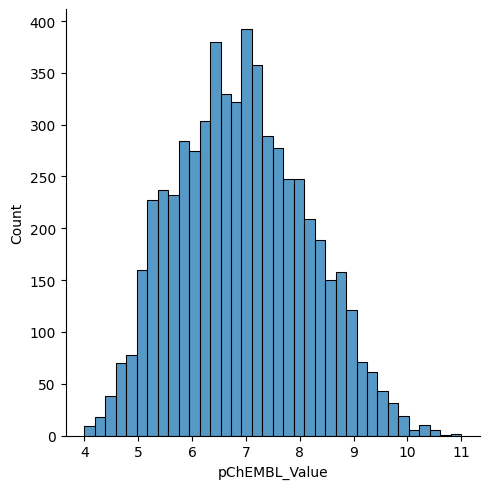

In [39]:
sns.displot(chembl_251_trgs)

In [40]:
np.percentile(chembl_251_trgs, 95)

9.0